# Лабораторная работа №4
# Решение оптимизационных задач с помощью генетических алгоритмов

# Задание

Лабораторная работа состоит из двух частей:

I. Использование генетического алгоритма для оптимизации раскладки клавиатуру для заданных слов;

II. Использование генетических алгоритмов для обучения интеллектуальных агентов.

Для выполнениче части I. требуется проделать следующие шаги:

1. Загрузить необходимые файлы (вариант со списком слов, макет клавиатуры и набор шрифтов).
2. Загрузить файл клавиатуры и шрифта в GoogleColab
3. Выбрать 3 слова согласно варианту и для каждого найти оптимальные раскладки клавиатуры, и визуализировать их с помощью макета и набора шрифтов. Если в слове присутствует дефис, то либо заменить на пробел, либо писать слитно.

Для выполнение части II. требуется выполнить следующие шаги:

1. Выбрать одну из предложенных игр с реализацией на JavaScript.
2. Обучить интеллектуального агента с помощью генетического алгоритма в среде без графического интерфейса на Python. В случае необходимости модифицировать код для получения лучших результатов.
3. Проверить качество агента в первоначальной среде на JavaScript.

Критерием выполнения II. части лабораторной работы является продолжительность жизни интеллектуального агента по результатам 3 партий. Среднее значение должно равняться не менее 30 секунд. При этом агент НЕ должен бездействовать.

Лабораторные выполняются на платформе Google Colab - просто перейдите по ссылке в начале ноутбука. Также можно работать с ноутбуками лабораторных локально.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы.

# Импорт библиотек

In [4]:
from PIL import Image, ImageDraw, ImageFont

import json
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks')

# Часть 1

По варианту нам достались следующие слова: уменьшительно-ласкательное, абстрагироваться и образование.

In [5]:
# Список слов согласно варианту
messages = [np.random.choice(['уменьшительно-ласкательное'], size=1000),
            np.random.choice(['абстрагироваться'], size=1000),
            np.random.choice(['образование'], size=1000)]

# Предобработка слов
df = pd.DataFrame(dict(msg=np.concatenate(messages)))
df.msg = df.msg.str.lower()
df.msg = df.msg.str.replace('ё', 'е').str.replace(u'\xa0', u' ').str.replace(u'\-', u' ')
df.msg = df.msg.str.replace('[^a-zа-я0-9\s?,.!]', '')

sequence = list(''.join(df[~df.msg.isna()].msg.values))
charmap = np.unique(sequence)

diffs_mask = df[~df.msg.isna()].msg.str.len().cumsum().values.copy()[:-1] - 1
diffs_boolean_mask = np.ones(len(sequence)-1, dtype=np.bool8)
diffs_boolean_mask[diffs_mask] = 0
sequence = list(''.join(df[~df.msg.isna()].msg.values))
bisequence = (pd.Series(sequence[:-1])+pd.Series(sequence[1:]))
BISEQUENCE_FREQS = bisequence.loc[diffs_boolean_mask].value_counts().reset_index()
BISEQUENCE_FREQS.columns = ['biseq', 'freq']
BISEQUENCE_FREQS

C:\Users\ds13\AppData\Local\Temp\ipykernel_35776\2531730597.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.msg = df.msg.str.replace('ё', 'е').str.replace(u'\xa0', u' ').str.replace(u'\-', u' ')
C:\Users\ds13\AppData\Local\Temp\ipykernel_35776\2531730597.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df.msg = df.msg.str.replace('[^a-zа-я0-9\s?,.!]', '')
C:\Users\ds13\AppData\Local\Temp\ipykernel_35776\2531730597.py:16: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  diffs_boolean_mask = np.ones(len(sequence)-1, dtype=np.bool8)


,biseq,freq
0,но,2000
1,ат,2000
2,ов,2000
3,те,2000
4,ел,2000
5,ль,2000
6,ьн,2000
7,ра,2000
8,ва,2000
9,ьс,1000


Инициализируем значения для настройки клавиатуры

In [6]:
# Инициализация раскладки клавиатуры
FIRST_ROW = [list('1234567890')]
SECOND_ROW = [list('йцукенгшщзх')]
THIRD_ROW = [list('фывапролджэ')]
FOURTH_ROW = [list('ячсмитьбю')]
FIFTH_ROW = [list(', .\n')]
ROWS = [FIRST_ROW, SECOND_ROW, THIRD_ROW, FOURTH_ROW, FIFTH_ROW]

KEYBINDS = \
[
# Первый ряд
[(68,68), (174, 68), (280, 68), (385, 68), (485, 68),
 (585, 68), (685, 68), (790, 68), (905, 68), (1010, 68)],
# Второй ряд
[(60, 201),(155, 201),(255, 201),(345, 201),(445, 201),
 (540, 201),(635, 201),(730, 201),(820, 201),(920, 201),(1015, 201)],
# Третий ряд
[(60, 350),(155, 350),(255, 350),(345, 350),(445, 350),
 (540, 350),(635, 350),(730, 350),(820, 350),(920, 350),(1015, 350)],
# Четвёртый ряд
[(155, 500),(255, 500),(345, 500),(445, 500),
 (540, 500),(635, 500),(730, 500),(820, 500),(920, 500)],
# Пятый ряд
[(224, 645),(530, 645),(855, 645),(980, 645)],
]

In [7]:
# Функция генерации раскладки
def generate_one():
    # mapper — это хромосома одной особи
    mapper = {}
    for k, row in enumerate(ROWS):
        for chng, row_lang in enumerate(row):
            for i, s in enumerate(row_lang):
                mapper[s] = (KEYBINDS[k][i][0]//10, KEYBINDS[k][i][1]//10)
    return mapper

In [8]:
# Функция отрисовки клавиатуры
def plot_keyboard(mapper, generation=0):
    keyboard_img = Image.open('keyboard.png').convert('RGB')
    d = ImageDraw.Draw(keyboard_img)
    font = ImageFont.truetype("Roboto-Bold.ttf", 30)
    for s, v in mapper.items():
        if s=='\n':
            s = 'Ent'
        if s==' ':
            s = '__'
        x, y = v[0]*10, v[1]*10

        d.text((x, y), s, font=font, fill=(255, 255, 255, 255))
    return keyboard_img.resize((500, 250))

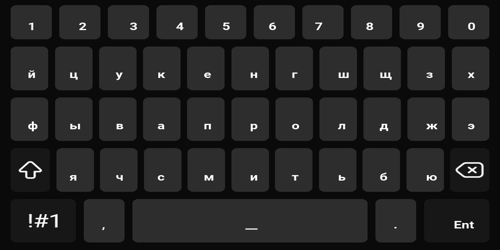

In [10]:
# Проврека корректности работы функции отрисовки клавиатуры
plot_keyboard(generate_one())

## Генетический алгоритм

### Функция приспособленности

In [11]:
# Функция приспособленности должна минимизировать расстояние, требуемое для написания слов
def get_scores(population):
    scores = []
    for new_mapper in population:
        cache = {}
        for i in charmap:
            for j in charmap:
                cache[i+j] = \
                    np.square(np.array(new_mapper.get(i, [-100, -100])) -
                              np.array(new_mapper.get(j, [-100, -100]))).sum()**0.5

        weights = BISEQUENCE_FREQS.biseq.map(cache)
        scores.append(BISEQUENCE_FREQS['freq'].dot(weights))
    return scores

### Функции мутации и скрещивания

In [12]:
# Функция мутации
def mutation(thingey, mutation_rate=0.05):
    # Мутация меняет местами mutation_rate*100 % клавиш друг с другом 
    keys = list(thingey.keys())
    values = list(thingey.values())

    mutation = (np.random.random(size=len(values))<mutation_rate).nonzero()[0]
    swap_index_to = np.random.choice(len(values),
                                     size=len(values),
                                     replace=False)

    new_values = np.array(values)
    for i, j in zip(mutation, swap_index_to[mutation]):
        new_values[[i,j]] = new_values[[j,i]]

    return {k:v for k,v in zip(keys, new_values)}

# Функция скрещивания
def crossover(thingeyA, thingeyB):
    # Скрещивание между двумя особями заменяет n-ое количество клавиш 1ой особи
    # n-ым количеством клавиш второй особи с сохранением 
    # порядка их встречаемости на раскладке (приоритет сверху-вниз, слево-направо) 
    keysA = list(thingeyA.keys())
    valuesA = list(thingeyA.values())

    keysB = list(thingeyB.keys())
    valuesB = list(thingeyB.values())

    ranksA = np.argsort(keysA)

    keysA = np.array(keysA)[ranksA].copy()
    keysB = np.array(keysB)[ranksA].copy()
    valuesA = np.array(valuesA)[ranksA].copy()
    valuesB = np.array(valuesB)[ranksA].copy()

    offset = np.random.randint(1, max(2, len(valuesA)-1))
    offspring = {k:v for k, v in zip(keysA[:offset], valuesA[:offset])}

    keysO = list(offspring.keys())
    valuesO = list(offspring.values())

    keys_rest = list(filter(lambda k: k not in offspring, thingeyB.keys()))
    valuesRest = valuesA[offset:]
    values = valuesB[offset:]
    ranking = (
        values + 
        (np.max(values)+1)**np.arange(len(values[0])).reshape(1, -1)
               ).sum(axis=1).argsort()
    for k, v in zip(keys_rest, valuesRest[ranking]):
        offspring[k] = v

    # Проверка, что клавиши не потерялись и не задублировались
    assert set(offspring.keys()
    ).symmetric_difference(thingeyA.keys()).__len__()==0
    assert set(map(tuple, offspring.values())
    ).symmetric_difference(set(map(tuple, thingeyA.values()))).__len__()==0
    return offspring

### Функции генерации начальной и новой популяций

In [13]:
# Генерация начальной популяции
def generate_initial(POPULATION_SIZE, mrate=0.0):
    # Первая раскладка неизменённая (может быть лучшее решение)
    population = [mutation(generate_one(), mutation_rate=0.0)]

    # Остальные со случайными перестановками клавиш
    for _ in range(max(0, POPULATION_SIZE - 1)):
        population.append(mutation(generate_one(), mutation_rate=mrate))
    return population

def generate_new_population(population, scores,
                            population_size=10,
                            elite_topk=1,
                            random_size=2,
                            ):
    new_population = []
    # Элитизм
    for topK in range(elite_topk):
        new_population.append(population[np.argsort(scores)[topK]].copy())
    # Трансформация функции приспособленности
    # оценка -> ранг -> экспоненцирование -> нормализация
    scores_ranks = scores.copy()
    for i, r in enumerate(np.argsort(scores)):
        scores_ranks[r] = i
    scores_ranks = np.exp(-np.array(scores_ranks)/len(scores_ranks)*4)
    scores_ranks /= scores_ranks.sum()

    # Рулеточный отбор особей для продолжения потомства
    for _ in range(max(0, population_size - elite_topk - random_size)):
        parentA, parentB = np.random.choice(len(scores), size=2, replace=True, p=scores_ranks)
        new_population.append(mutation(crossover(population[parentA], population[parentB])))
    # Добавление особей со стороны
    for _ in range(max(0, random_size)):
        if np.random.random() < 0.5:
            # Полностью случайная раскладка с перемешанными клавишами
            new_population.append(mutation(generate_one(), 1.0))
        else:
            # Случайно изменённая лучшая (hill climbing)
            new_population.append(mutation(new_population[0]))

    return new_population

## Оптимизация раскладки клавиатуры с помощью генетического алгоритма

In [14]:
# Параметры ГА
POPULATION_SIZE = 300
ELITISM_TOPK = 15
RANDOM_SIZE = 100
NUM_GENERATIONS = 30
NUM_RESTARTS = 15

bscore = np.inf
stats = []
for restart in range(NUM_RESTARTS):
    print('Рестарт: %d' % (restart+1))
    population = generate_initial(POPULATION_SIZE, 1.0)
    for generation in range(NUM_GENERATIONS):
        scores = get_scores(population)
        population = generate_new_population(population, scores,
                                            POPULATION_SIZE,
                                            ELITISM_TOPK,
                                            RANDOM_SIZE)
        stats.append((generation, min(scores), max(scores), np.mean(scores)))
        if min(scores) < bscore:
            bscore = min(scores)
            bimg = plot_keyboard(population[0], generation)
            print(('Поколение: %d\tЛучшее расстояние: %.1f\t'
                   'Худшее расстояние: %.1f\t'
                   'Среднее расстояние в популяции: %.1f')%stats[-1])

Рестарт: 1
Поколение: 0	Лучшее расстояние: 1382174.7	Худшее расстояние: 2841830.8	Среднее расстояние в популяции: 2198922.2
Поколение: 1	Лучшее расстояние: 1321124.0	Худшее расстояние: 3108789.5	Среднее расстояние в популяции: 2035698.1
Поколение: 2	Лучшее расстояние: 1231564.8	Худшее расстояние: 2641597.4	Среднее расстояние в популяции: 1896044.0
Поколение: 3	Лучшее расстояние: 1203328.8	Худшее расстояние: 2663662.4	Среднее расстояние в популяции: 1849828.9
Поколение: 4	Лучшее расстояние: 1187834.6	Худшее расстояние: 2725903.9	Среднее расстояние в популяции: 1826696.3
Поколение: 5	Лучшее расстояние: 1158760.2	Худшее расстояние: 2736337.9	Среднее расстояние в популяции: 1799068.4
Поколение: 6	Лучшее расстояние: 1131171.1	Худшее расстояние: 3055070.4	Среднее расстояние в популяции: 1787194.0
Поколение: 8	Лучшее расстояние: 1091758.8	Худшее расстояние: 2861878.3	Среднее расстояние в популяции: 1752039.7
Поколение: 9	Лучшее расстояние: 1009634.9	Худшее расстояние: 2698341.2	Среднее рассто

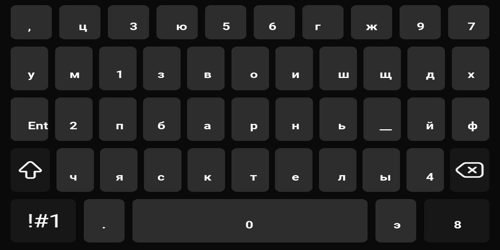

In [15]:
# Отображение лучшей раскладки
bimg

# Часть 2


## DoodleJump

In [ ]:
# Объявление глобальных переменных
def init_states():
    settings = dict(
        width = 375,
        height = 667,
        platformWidth = 65,
        platformHeight = 20,

        gravity = 0.33,
        drag = 0.3,
        bounceVelocity = -12.5,

        minPlatformSpace = 15,
        maxPlatformSpace = 20,
        keydown = False,
        score = 0,
    )
    settings['platformStart'] = settings['height'] - 50

    platforms = [dict(x=settings['width'] / 2 - settings['platformWidth'] / 2,
                      y=settings['platformStart'])]
    y = settings['platformStart']
    while (y > 0):
        y -= settings['platformHeight'] + \
             np.random.randint(settings['minPlatformSpace'],
                               settings['maxPlatformSpace'])

        while True:
            x = np.random.uniform(25, settings['width'] \
                                  - 25 - settings['platformWidth'])
            if not ((y > settings['height'] / 2) and
                    (x > settings['width'] / 2 
                     - settings['platformWidth'] * 1.5) and
                    (x < settings['width'] / 2 
                     + settings['platformWidth'] / 2)):
                break
        platforms.append(dict(x=x, y=y))

    doodle = dict(
      width=40,
      height=60,
      x=settings['width'] / 2 - 20,
      y=settings['platformStart'] - 60,
      dx=0,
      dy=0,
      playerDir=0,
      prevDoodleY=settings['platformStart'] - 60,
    )

    return doodle, platforms, settings

doodle, platforms, settings = init_states()

### Логика игры

In [ ]:
def restart():
    doodle, platforms, settings = init_states()
    return doodle, platforms, settings


def loop(doodle, platforms, settings):
    doodle['dy'] += settings['gravity']

    if (doodle['y'] < settings['height'] / 2 and doodle['dy'] < 0):
        for i, _ in enumerate(platforms):
            platforms[i]['y'] -= doodle['dy']

        while (platforms[-1]['y'] > 0):
            platforms.append(dict(
                x=np.random.uniform(25,
                                    settings['width'] - 25
                                    - settings['platformWidth']),
                y=np.random.uniform(platforms[-1]['y'] -
                                    (settings['platformHeight'] +
                                     np.random.uniform(
                                         settings['minPlatformSpace'],
                                         settings['maxPlatformSpace']))
                                    )
                                )
                            )

            settings['minPlatformSpace'] = min(settings['minPlatformSpace'] 
                                               + 0.5,
                                               settings['height'] / 2 - 0.5)
            settings['maxPlatformSpace'] = min(settings['maxPlatformSpace'] 
                                               + 0.5,
                                               settings['height'] / 2)
    else:
        doodle['y'] += doodle['dy']

    if not settings['keydown']:
        if (doodle['playerDir'] < 0):
            doodle['dx'] += settings['drag'];
            if (doodle['dx'] > 0):
                doodle['dx'] = 0
                doodle['playerDir'] = 0
        elif (doodle['playerDir'] > 0):
            doodle['dx'] -= settings['drag']

            if (doodle['dx'] < 0):
                doodle['dx'] = 0
                doodle['playerDir'] = 0

    doodle['x'] += doodle['dx']

    if (doodle['x'] + doodle['width'] < 0):
        doodle['x'] = settings['width']
    elif (doodle['x'] > settings['width']):
        doodle['x'] = -doodle['width']

    for platform in platforms:
        if (
          (doodle['dy'] > 0) and
          (doodle['prevDoodleY'] + doodle['height'] <= platform['y']) and
          (doodle['x'] < platform['x'] + settings['platformWidth']) and
          (doodle['x'] + doodle['width'] > platform['x']) and
          (doodle['y'] < platform['y'] + settings['platformHeight']) and
          (doodle['y'] + doodle['height'] > platform['y'])
        ):
            doodle['y'] = platform['y'] - doodle['height']
            doodle['dy'] = settings['bounceVelocity']

    doodle['prevDoodleY'] = doodle['y']
    platforms_cleared = len(platforms)
    platforms = list(filter(lambda platform: platform['y'] < settings['height'],
                            platforms))
    platforms_cleared -= len(platforms)
    settings['score'] += platforms_cleared

    if doodle['y'] > settings['height'] + doodle['height']:
        return -1
    return 0

### Действия агента

In [ ]:
actionMap = {0: 37, # Движение влево
             1: 39, # Движение вправо
             2: -1} # Ожидание

def apply_action(doodle, platforms, settings, actionId):
    key = actionMap[actionId]

    if key == 37:
        settings['keydown'] = True
        settings['playerDir'] = -1
        doodle['dx'] = -3
    elif key == 39:
        settings['keydown'] = True
        settings['playerDir'] = 1
        doodle['dx'] = 3
    else:
        settings['keydown'] = False

### Признаки для интеллектуального агента

In [ ]:
# Агент видел значения в этих пикселях
sensor_web = np.meshgrid(np.arange(-settings['width']*2//3,
                                   +settings['width']*2//3, 50),
                         np.arange(-settings['height']*2//3,
                                   +settings['height']*2//3, 75))
sensor_web = np.concatenate([sensor_web[0].flatten()[:, None],
                             sensor_web[1].flatten()[:, None]], axis=1)

In [ ]:
def get_features(doodle, platforms, settings):
    points = np.array([(p['x'], p['y']) for p in platforms])

    sensor_x = (sensor_web[:, 0]*1 + doodle['x']) % settings['width']
    sensor_y = np.clip((sensor_web[:, 1]*1 + doodle['y']),
                       1, settings['height']-1)

    xx = sensor_x.reshape(-1, 1) - points[:, 0]
    yy = sensor_y.reshape(-1, 1) - points[:, 1]
    cond1 = (xx - settings['platformWidth']) < 0
    cond2 = (xx) > 0
    cond3 = (yy - settings['platformHeight']) < 0
    cond4 = (yy) > 0

    sensors = ((cond1*cond2*cond3*cond4).any(axis=1))*1.
    return np.concatenate([sensors, [doodle['dx'],
                                     doodle['dy'],
                                     1]])

%timeit get_features(doodle, platforms, settings)

### "Мозги" агента

In [ ]:
def get_one(h1=5, n_classes=3):
    W = np.random.normal(size=(sensor_web.shape[0]+3, h1))
    W2 = np.random.normal(size=(h1, n_classes))
    return W, W2

def softmax(x):
    xe = np.exp(x-x.max())
    return xe/xe.sum()

def getAction(doodle, platforms, settings, weights):
    W, W2 = weights
    logits = np.maximum(W.T.dot(get_features(doodle, platforms, settings)),
                        0).dot(W2)
    # Действия выбираются не детерминированно, а вероятностно
    return np.random.choice(np.arange(logits.size), p=softmax(logits))

getAction(doodle, platforms, settings, get_one())

## Генетический алгоритм

### Функция приспособленности

In [ ]:
def get_score(W, patience=100, return_actions=False):
    doodle, platforms, settings = restart()
    maxScore_patience = patience
    maxScore_prev = settings['minPlatformSpace']
    actions = []
    xcoords = []
    action = getAction(doodle, platforms, settings, W)
    for _ in range(int(5e4)):
        if loop(doodle, platforms, settings) == -1:
            break
        # симуляция запоздалой реакции агента
        if np.random.random() < 0.25:
            action = getAction(doodle, platforms, settings, W)
        actions.append(action)
        xcoords.append(doodle['x'])
        apply_action(doodle, platforms, settings, action)
        if  settings['minPlatformSpace'] > maxScore_prev:
            maxScore_prev = settings['minPlatformSpace']
            maxScore_patience = patience
        maxScore_patience -= 1
        if maxScore_patience < 0:
            break
    if return_actions:
        return actions, xcoords, settings['minPlatformSpace']
    return settings['minPlatformSpace']

### Функции мутации и скрещивания

In [ ]:
def mutate(weights, mutation_rate=0.028):
    W, W2 = weights
    dW, dW2 = get_one()
    dM, dM2 = get_one()
    return W + dW*(dM>0)*mutation_rate, W2 + dW2*(dM2>0)*mutation_rate


def crossover(W1, W2):
    result = []
    for w1, w2 in zip(W1, W2):
        maskW = np.random.random(w1.shape)<0.5
        result.append(w1*maskW+w2*(~maskW))
    return result

### Функции популяций

In [ ]:
def generate_random(population, size):
    new_population = []
    for _ in range(size):
        if np.random.random()<0.5:
            new_population.append(get_one())
        else:
            new_population.append(mutate(population[0]))
    return new_population


def selection(population, scores, topK=2):
    scores = np.array(scores)*1.
    scores /= scores.sum()
    elitismTopK = np.argsort(scores)[::-1][:topK//2]
    roulleteTopK = np.random.choice(len(scores),
                                    p=scores,
                                    size=topK//2)

    new_population = [tuple(map(lambda x: x.copy(), population[i]))
                      for i in elitismTopK]+\
                     [tuple(map(lambda x: x.copy(), population[i]))
                      for i in roulleteTopK]

    return new_population


def breed(population, scores, nChilds=10):
    scores = np.array(scores)*1.
    scores /= scores.sum()
    parents = np.random.choice(len(scores),
                               p=scores,
                               size=(nChilds, 2))

    new_population = []
    for parentA, parentB in parents:
        new_population.append(mutate(crossover(population[parentA],
                                               population[parentB])))

    return new_population

def factorize(population, factor=3):
    for i, p in enumerate(population):
        population[i] = tuple([np.array([[int(10**factor*w)/10**factor
                                          for w in W]
                                         for W in pp])
                               for pp in p])
    return population


def get_new_population(population, scores, topK=4, randomNum=10):
    return factorize(
    selection(population, scores, topK) + \
    breed(population, scores,
          nChilds=max(0, len(population) - randomNum - topK)) + \
    generate_random(population, randomNum)
    )

### Вспомогательные функции

In [ ]:
def get_scores(population, patience=100):
    scores = []
    for W in population:
        scores.append(get_score(W, patience))
    return scores

In [ ]:
# Сохранение чекпоинта "мозгов" интеллектуального агента
def save_thingey(best_thingey, score):
    with open('doodlejump_weights_%.1f.js'%score, 'w') as f:
        f.write('var sensorWeb = %s;\n\nvar W = %s;\n\nvar W2 = %s;\n'%
                (json.dumps([[int(w) for w in W] for W in sensor_web]),
                 json.dumps([[int(1e2*w)/1e2 for w in W]
                             for W in best_thingey[0]]),
                 json.dumps([[int(1e2*w)/1e2 for w in W]
                             for W in best_thingey[1]])))

## Обучение агента

In [ ]:
# Параметры
POPULATION_SIZE = 256
RANDOM_SIZE = 12
ELITE_SIZE = 6
NUM_GENERATIONS = 300
NUM_REPEATS = 3
NUM_RESTARTS = 1
PATIENCE = lambda x: 100*((x+2)//2)
population = [get_one() for _ in range(POPULATION_SIZE)]

best_thingey = None
best_score = 0

for n_restart in range(NUM_RESTARTS):
    print('='*50)
    print('Cтарт перезапуска №%d'%(n_restart+1))
    print('Лучшая пока что: %.1f'%best_score)
    print('='*50)
    population = [get_one() for _ in range(POPULATION_SIZE)]
    for generation in range(NUM_GENERATIONS):
        scores = 0.
        for _ in range(NUM_REPEATS):
            scores += np.array(get_scores(population, PATIENCE(generation)))**4
        scores /= NUM_REPEATS

        population = get_new_population(population, scores,
                                        topK=ELITE_SIZE,
                                        randomNum=RANDOM_SIZE)
        bscore = max(scores)**0.25
        if generation%5 == 0 or bscore > best_score:
          if bscore > best_score:
            best_score = bscore
            best_thingey = [x.copy() for x in population[0]]
          print('Рестарт: %d\tПоколение: %d\tЗначение: %.1f'%(n_restart+1,
                                                                generation,
                                                                bscore))
          if bscore > 120:
              save_thingey(best_thingey, best_score)
              save_thingey(best_thingey, best_score)